In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

input_file = "datasets/credit_risk_dataset.csv"
pd.set_option('display.max_columns', None)
df = pd.read_csv(input_file, on_bad_lines='skip')

Visualise the data with data types, categories of non int/float columns, correleation matrix, nan values and ground truth data

In [2]:
def visualisation(vis, gt_col):
    print('\n', '----------- column dtypes -----------', '\n')
    print(vis.dtypes)
    print('\n', '----------- data categories -----------', '\n')
    for column in vis.columns.values:
        if vis[column].dtype != np.int64 and vis[column].dtype != np.float64:
            print(column, vis[column].unique())
    print('\n', '----------- correlation score -----------', '\n')
    corr_matrix = vis.corr(numeric_only=True).abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().sort_values(ascending=False))
    print(sol)
    print('\n', '----------- rows with nan values for each column -----------', '\n')
    print(vis.isnull().sum())
    print('total rows with nan values:', vis.isnull().sum().sum())
    print('\n', '----------- number of groundtruth data -----------', '\n')
    print(vis.groupby([gt_col])[gt_col].count())
    print('\n', '-----------------------------------------', '\n')

In [3]:
visualisation(df, gt_col='loan_status')


 ----------- column dtypes ----------- 

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

 ----------- data categories ----------- 

person_home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file ['Y' 'N']

 ----------- correlation score ----------- 

person_age           cb_person_cred_hist_length    0.859133
loan_amnt            loan_percent_income           0.572612
loan_status          loan_percent_income         

It is observed that there are some outliers where their working years larger than their ages

In [4]:
def ten_years_old_with_thirty_years_experience(df):
    df.drop(df[df['person_emp_length'] >= df['person_age']].index, inplace = True)
    # l = len(df[df['person_emp_length'] >= df['person_age']].index)
    # print('dropped %d outliers' %l)
    return df

Divide the ages into different groups

In [5]:
def age_preprocess(df, col):
    df = df[df[col]<60].reset_index(drop=True)  # drop the data that age > 60
    bins= [19,25,30,35,40,45,50,55,60]
    labels = ['20-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60']
    df[col] = pd.cut(df[col], bins=bins, labels=labels)
    return df

Encode all column with LabelEncoder for training

In [6]:
def df_label_encoder(df):
    le = preprocessing.LabelEncoder()
    columns = df.columns.values
    for column in columns:
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            df[column] = le.fit_transform(df[column].astype(str))
    return df

Normalize all data to the range of 0 to 1

In [7]:
def col_normalization(df):
    for i in df:
        df[i] = df[i] /df[i].abs().max()
    return df

The ground truth data is not balanced, below script will balance the data of ground truth == 0 and ground truth == 1
And follow with train_test_split function to split the data into train and evaluation dataset

In [8]:
def sample_dataset(df, gt_col, test_ratio):
    feature_name = df.drop([gt_col], axis=1).columns
    df_target_1 = df.loc[df[gt_col] == 1].reset_index(drop=True)
    df_target_0 = df.loc[df[gt_col] == 0].sample(n=df_target_1.shape[0])  # balance the data
    df_sampled = pd.concat([df_target_1, df_target_0], ignore_index=True)
    df_sampled = df_sampled.sample(frac=1).reset_index(drop=True)  # shuffle the data
    print(df_sampled.groupby([gt_col])[gt_col].count())
    X = df_sampled.drop([gt_col], axis=1).values
    y = df_sampled[gt_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio,random_state=0)
    return df_sampled, X_train, X_test, y_train, y_test

Preprocess the original data with above functions

In [9]:
df = ten_years_old_with_thirty_years_experience(df)
df = df.dropna()
df = age_preprocess(df, 'person_age')
df = df_label_encoder(df)
df = col_normalization(df)

All data have been encoded into the range between 0 and 1, outliers and nan values are dropped

In [10]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0.0,0.004706,0.666667,0.131579,0.2,0.166667,0.028571,0.479759,0.0,0.120482,0.0,0.066667
1,0.0,0.004706,0.000000,0.026316,0.6,0.333333,0.157143,0.554264,1.0,0.686747,0.0,0.100000
2,0.0,0.032111,1.000000,0.105263,0.6,0.333333,1.000000,0.655900,1.0,0.638554,0.0,0.066667


Balance the dataset and split the data into train and evaluation dataset with ratio 0.1

In [11]:
df_balanced, X_train, X_test, y_train, y_test = sample_dataset(df, gt_col='loan_status', test_ratio=0.1)

loan_status
0.0    6180
1.0    6180
Name: loan_status, dtype: int64


Build the model with CatBoostClassifier, no cat_features is required as we have encoded all data already

In [12]:
model = CatBoostClassifier(
    iterations=4400,
    learning_rate=0.01,
    random_seed=0
)

model.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        verbose=True
)

0:	learn: 0.6841611	test: 0.6843156	best: 0.6843156 (0)	total: 88.1ms	remaining: 6m 27s
1:	learn: 0.6750057	test: 0.6753215	best: 0.6753215 (1)	total: 97.9ms	remaining: 3m 35s
2:	learn: 0.6665016	test: 0.6669440	best: 0.6669440 (2)	total: 106ms	remaining: 2m 35s
3:	learn: 0.6577187	test: 0.6582495	best: 0.6582495 (3)	total: 115ms	remaining: 2m 6s
4:	learn: 0.6495592	test: 0.6501112	best: 0.6501112 (4)	total: 123ms	remaining: 1m 48s
5:	learn: 0.6411711	test: 0.6417646	best: 0.6417646 (5)	total: 132ms	remaining: 1m 36s
6:	learn: 0.6348398	test: 0.6352888	best: 0.6352888 (6)	total: 139ms	remaining: 1m 27s
7:	learn: 0.6281926	test: 0.6283588	best: 0.6283588 (7)	total: 148ms	remaining: 1m 21s
8:	learn: 0.6225742	test: 0.6226712	best: 0.6226712 (8)	total: 156ms	remaining: 1m 16s
9:	learn: 0.6173763	test: 0.6174053	best: 0.6174053 (9)	total: 165ms	remaining: 1m 12s
10:	learn: 0.6121834	test: 0.6121639	best: 0.6121639 (10)	total: 173ms	remaining: 1m 8s
11:	learn: 0.6066867	test: 0.6064858	best

In this notebook, we consider the problem of data bias on the ground truth and balance the data before training.  
The model can reach 86.8% of accuracy on balanced dataset, where the same model can perform ~94% of accuracy on the full dataset.

In [13]:
print(model.score(X_test, y_test))

0.872168284789644


In [15]:
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, fbeta_score

# Predict the labels and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate and print recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Calculate and print precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# Calculate and print F-beta scores
f0_5 = fbeta_score(y_test, y_pred, beta=0.5)
print(f'F0.5 Score: {f0_5 * 100:.2f}%')

f1 = fbeta_score(y_test, y_pred, beta=1)
print(f'F1 Score: {f1 * 100:.2f}%')

f2 = fbeta_score(y_test, y_pred, beta=2)
print(f'F2 Score: {f2 * 100:.2f}%')

Accuracy: 87.22%
Recall: 82.44%
Precision: 91.02%
F0.5 Score: 89.17%
F1 Score: 86.52%
F2 Score: 84.02%


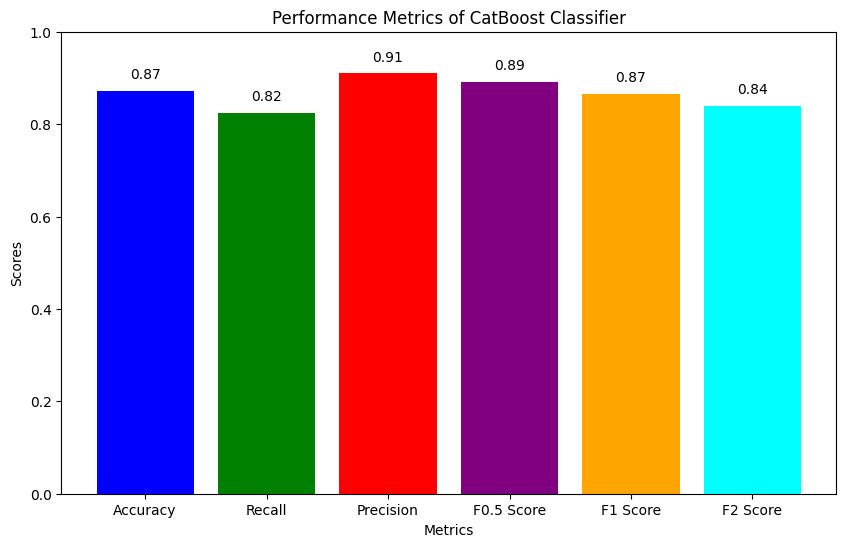

In [16]:
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, fbeta_score

# Predict the labels and probabilities
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate F-beta scores
f0_5 = fbeta_score(y_test, y_pred, beta=0.5)
f1 = fbeta_score(y_test, y_pred, beta=1)
f2 = fbeta_score(y_test, y_pred, beta=2)

# Prepare data for plotting
metrics = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision,
    'F0.5 Score': f0_5,
    'F1 Score': f1,
    'F2 Score': f2
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics of CatBoost Classifier')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# Adding value labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.show()